## 5 머신러닝의 기본요소

1 일반화:머신 러닝의 목표 <br>
2 머신 러닝 모델 평가 <br>
3 훈련 성능 향상하기 <br>
4 일반화 성능 향상하기
5 요약 <br><br>

여기서는 정확한 모델평가의 중요성 및 훈련과 일반화 사이의 균형을 강조하면서 머신러닝에 대한 새로우 직관을 확고한 개념으로 정립 <br>


### 5.1 일반화: 머신러닝의 목표

머신러닝의 근본적인 이슈는 최적화와 일반화 사이의 줄다리기 <br>, 
- <b>최적화</b>는 가능한 훈련 데이터에서 최긔어 성능을 얻으려고 모델을 조정하는 과정(머신러닝에서 학습에 해당됨) <br>
- <b>일반화</b>는 훈련된 모델이 이전에 본적 없는 데이터에서 얼마나 잘 수행되는지 의미, 목표는 좋은 일반화 성능을 얻는 것, 일반화 성능을 제어할 방법은 없음. 단지 모델을 훈련 데이터에 맞출 수만 있음. <br>

#### 5.1.1 과소적합과 과대적합
- <b>과소적합</b>은 훈련 데이터의 손실이 낮아질수록 테스트 데이터의 손실도 낮아짐, 즉, 네트워크가 훈련 데이터에 있는 모든 관련 패턴을 학습하지 못했음 <br>
- But, 훈련 데이터에서 훈련을 특정 횟수만큼 반복하고 난 후에는 일반화 성능이 더 이상 높아지지 않으며 검증 세트의 성능이 멈추고 감소되기 시작함 <br>

- <b>잡은 섞인 훈련 데이터</b> <br>: 모델을 이상치에 맞추려고 하면 일반화 성능이 감소됨
- <b>불확실한 특성</b> <br>:
- <b>드문 특성과 가짜 상관관계</b> <br>: 가짜 상관관계를 만들어 내는 데 특성 값이 몇번만 등장할 필요가 없다는 것.

#### 5-1 MNIST에 백색 잡음 픽셀과 0픽셀 추가하기

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255
train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 784))], axis=1)
train_images_with_zeros_channels = np.concatenate([train_images, np.zeros((len(train_images), 784))], axis=1)

#### 코드 5-2 백색 잡음과 0을 추가한 MNIST 데이터에서 모델 훈련하기

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/10
375/375 [==============================] - 13s 32ms/step - loss: 0.6244 - accuracy: 0.8087 - val_loss: 0.3080 - val_accuracy: 0.9045
Epoch 2/10
375/375 [==============================] - 12s 31ms/step - loss: 0.2589 - accuracy: 0.9197 - val_loss: 0.2052 - val_accuracy: 0.9409
Epoch 3/10
375/375 [==============================] - 12s 31ms/step - loss: 0.1658 - accuracy: 0.9490 - val_loss: 0.1649 - val_accuracy: 0.9517
Epoch 4/10
375/375 [==============================] - 12s 31ms/step - loss: 0.1167 - accuracy: 0.9641 - val_loss: 0.1738 - val_accuracy: 0.9502
Epoch 5/10
375/375 [==============================] - 12s 31ms/step - loss: 0.0887 - accuracy: 0.9729 - val_loss: 0.1304 - val_accuracy: 0.9632
Epoch 6/10
375/375 [==============================] - 12s 32ms/step - loss: 0.0655 - accuracy: 0.9785 - val_loss: 0.1751 - val_accuracy: 0.9529
Epoch 7/10
375/375 [==============================] - 12s 31ms/step - loss: 0.0483 - accuracy: 0.9845 - val_loss: 0.1177 - val_accuracy:

#### 코드 5-3 검증 정확도 비교 그래프 그리기

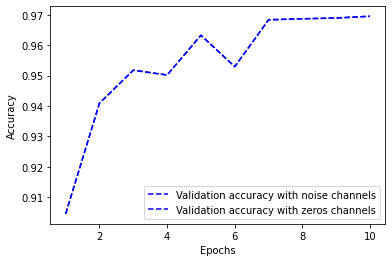

In [3]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_noise.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b--",
        label = "Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
        label = "Validation accuracy with zeros channels")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 잡음을 더 많이 섞을수록 정확도는 더 감소, 잡음 특성은 필연적으로 과대적합을 유발시킴
# 특성 선택을 수행하는 것이 일반적, 특선 선택을 하는 일반적인 방법은 가용한 각 특성에 대해 어떤 유용성 점수를 계산하는 것
# 즉, 특성과 레이블 사이의 상호 의존 정보(mutual information)처럼 작업에 대해 특성이 얼마나 유익한지 측정
# 그다음 임계값을 넘긴 특성만 사용 

#### 코드 5-4 랜덤하게 섞은 레이블로 MNIST 모델 훈련하기

In [4]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='softmax')
])

model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_images, random_train_labels,
         epochs=100,
         batch_size=128,
         validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 8s 21ms/step - loss: 2.3866 - accuracy: 0.1018 - val_loss: 2.3258 - val_accuracy: 0.0998
Epoch 2/100
375/375 [==============================] - 8s 20ms/step - loss: 2.3090 - accuracy: 0.1118 - val_loss: 2.3154 - val_accuracy: 0.1061
Epoch 3/100
375/375 [==============================] - 8s 21ms/step - loss: 2.2961 - accuracy: 0.1244 - val_loss: 2.3227 - val_accuracy: 0.0984
Epoch 4/100
375/375 [==============================] - 8s 20ms/step - loss: 2.2842 - accuracy: 0.1353 - val_loss: 2.3241 - val_accuracy: 0.1013
Epoch 5/100
375/375 [==============================] - 8s 20ms/step - loss: 2.2684 - accuracy: 0.1485 - val_loss: 2.3319 - val_accuracy: 0.1016
Epoch 6/100
375/375 [==============================] - 8s 21ms/step - loss: 2.2495 - accuracy: 0.1623 - val_loss: 2.3479 - val_accuracy: 0.1022
Epoch 7/100
375/375 [==============================] - 8s 20ms/step - loss: 2.2267 - accuracy: 0.1785 - val_loss: 2.3616 - val_accuracy:

<b>매니폴드 가설</b>은 실제 세상의 모든 데이터가 (이 데이터가 인코딩된) 고차원 공간안에 있는 저차원 매니폴드에 놓여있다고 가정 <br><br>
- 머신러닝 모델은 가능한 입력 공간안에서 비교적 간단하고, 저차원이며, 매우 조저직은 부분공간만 학습하면 된다.<br>
- 하나 안에서 두 입력 사이를 보간(interpolation)하는 것이 항상 가능함, 즉, 연속적인 경로를 따라 한 입력에서 다른 입력으로 변형할 때 모든 모인트가 이 매니폴드에 속함 <br>

#### 코드 5-5 홀드아웃 검증 구현 예

In [ ]:
num_validation_samples = 10000
np.random.shuffle(data)  # 일반적으로 데이터를 섞는것이 좋다
validation_data = data[:num_validation_samples]  # 검증 세트를 만든다.
training_data = data[num_validation_samples:]  # 훈련 세트를 만든다.
model = get_model()
model.fit(training_data, ...)
vlidation_score = model.evaluate(validation_data, ...)
model = get_model()
model.fit(np.concatenate([training_data, validation_data]), ...)
test_score = model.evaluate(test_data, ...)

# 단점: 데이터가 적ㅇ르떄는 검증 세트와 테스트 세트의 샘플이 너무 적어 주어진 전체 데이터를 통계적으로 대표하지 못함

#### K-fold 교차 검증

동일한 크기를 가진 K개의 분할로 나눔 <br>
↓ <br>
각 분할 i에 대해 남은 K-1개의 분할로 모델을 훈련하고 분할 i에서 모델을 평가 <br> 
↓ <br>
최종 점수는 이렇게 얻은 K개의 점수를 평균 <br><br>


#### 코드 5-6 K-겹 교차 검증 구현 예

In [ ]:
k = 3
num_validation_samples = len(data)//k
np.random.shuffle(data)
validation_scores =[]
for fold in range(k):
    validation_data = data[num_validation_samples*fold:
                        num_validation_samples*(fold+1)]
    training_data = np.concatenate(
                    data[:num_validation_sampels*fold],
                    data[:num_validation_sampels*(fold+1):])
    model = get_model() # 훈련되지 않은 새로운 모델을 만듦
    model.fit(training_data, ...)
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_data)
validation_score = np.average(validation_scores)  # 검증점수: K개의 폴드 검증 점수 평균
model = get_model() # 테스트 데이터를 제외한 전체 데이터로 최종 모델을 훈련
model.fit(data, ...)
test_score = model.evaluate(etst_data, ...)

#### 셔플링을 사용한 반복 K-겹 교차 검증

- 비교적 가용 데이터가 적고 가능한 정확하게 모델을 평가하고자 할떄 사용 <br>
- K-겹 교차 검증을 여러 번 적용하되 K개의 분할로 나누기 전에 매전 데이터를 무작위로 섞음 <br>
- 최종 점수는 모든 K-겹 교차 검증을 실행해서 얻은 점수의 평균 <br>
- 결국 P*K개(P는 반복횟수)의 모델을 훈련하고 평가하므로 비용이 매우 많이 든다 <br>

### 5.2.2 상식 수준의 기준점 넘기

항상 넘어야 할 간단한 기준점을 정해야 한다. 


### 5.2.3 모델 평가에 대해 유념해야할 점
- 대표성 있는 데이터: 훈련세트에는 0~7 숫자만 담겨 있고 테스트 세트에는 8~9 숫자만 담기게 될 수도 있기 떄문에 훈련세트와 테스트 세트로 나누기 전에 데이터를 무작위로 섞는것이 일반적이다 <br>
- 시간의 방향: 무작위로 섞어서는 절대 안된다, 미래의 정보가 누설되기 때문에. 이런 문제에서는 훈련 세트에 있는 데이터보다 테스트 세트에 있는 모든 데이터가 미래의 것이어야 한다. <br>
- 데이터 중복: 절대 안됨 <br>

## 5.3 훈련 성능 향상하기

최적적합 모델을 얻으려면 먼저 과대적합되어야 한다, 이 경계가 어디인지 미리 알지 못하기 때문에 경계를 찾으려면 넘어가 봐야한다, => 이 문제를 다루기 시작할 때 초기 목표는 약간의 일반화 능력을 보이고 과대적합할 수 있는 모델을 얻는 것이다. <br>
이 때 발생할수 있는 문제 3가지: <br>
1. 훈련이 되지 않는다: 시간이 지나도 훈련 손실이 줄어들지 않는다. <br>
2. 훈련은 잘 시작되었지만 모델이 의미 있는 일반화를 달성하지 못한다: 상식 수준의 기준점을 넘어설 수 없다. <br>
3. 시간이 지남에 따라 훈련과 검증 손실이 모두 줄어들고 기준점을 넘어설 수 있지만 과데적합되지 않을 것 같다. 여전히 과소적합 상태 <br>

=> 이를 해결하기 위해 1번째 큰 이정표(상식 수준의 기준점을 넘을 수 있어 약간의 일반화 능력이 있고 과대적합할 수 있는 모델을 얻는 것)를 달성하는 방법을 알아겠음 <br><br>

### 5.3.1 경사하강법의 핵심 파라미터 튜닝하기

훈련이 시작되지 않거나 너무 일찍 중단됨, 손실도 멈춰 있음 => 랜덤한 데이터에서도 모델을 훈련할 수 있다! <br>

- 옵티마이저 선택, 모델 가중치의 초깃값 분포, 학습률 ,배치크기 => 이 모든 파라미터는 상호 의존적이다. <br><br>


#### 코드 5-7 잘못된 높은 학습률로 MNIST 모델 훈련하기

In [5]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="softmax")
])

model.compile(optimizer=keras.optimizers.RMSprop(1.),
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split =0.2)

# 이 모델은 30~40%이고 이를 넘어서지 못한다, lr을 1e-2로 낮춰보겠음

Epoch 1/10
375/375 [==============================] - 8s 21ms/step - loss: 323.6319 - accuracy: 0.2905 - val_loss: 2.3413 - val_accuracy: 0.2395
Epoch 2/10
375/375 [==============================] - 8s 20ms/step - loss: 3.6882 - accuracy: 0.2085 - val_loss: 2.2544 - val_accuracy: 0.2160
Epoch 3/10
375/375 [==============================] - 8s 21ms/step - loss: 4.1423 - accuracy: 0.2157 - val_loss: 2.6029 - val_accuracy: 0.1931
Epoch 4/10
375/375 [==============================] - 8s 20ms/step - loss: 2.8359 - accuracy: 0.2138 - val_loss: 2.3223 - val_accuracy: 0.2255
Epoch 5/10
375/375 [==============================] - 8s 21ms/step - loss: 2.4354 - accuracy: 0.2303 - val_loss: 10.7874 - val_accuracy: 0.2418
Epoch 6/10
375/375 [==============================] - 7s 20ms/step - loss: 2.7866 - accuracy: 0.2279 - val_loss: 2.0127 - val_accuracy: 0.2438
Epoch 7/10
375/375 [==============================] - 8s 20ms/step - loss: 2.4076 - accuracy: 0.2338 - val_loss: 2.4589 - val_accuracy: 0.2

#### 코드 5-8 같은 모델을 적절한 학습률로 훈련하기

이제 모델 훈련이 가능하다, 만약 또 발생하면 다음을 시도해볼수 있다. <br>
- 학습률을 낮추거나 높인다 <br>
- 배치 크기를 증가시킨다 <br>

In [6]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='softmax'),
])

model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 8s 21ms/step - loss: 0.3620 - accuracy: 0.9109 - val_loss: 0.1662 - val_accuracy: 0.9554
Epoch 2/10
375/375 [==============================] - 8s 20ms/step - loss: 0.1408 - accuracy: 0.9639 - val_loss: 0.1759 - val_accuracy: 0.9626
Epoch 3/10
375/375 [==============================] - 8s 21ms/step - loss: 0.1130 - accuracy: 0.9731 - val_loss: 0.2335 - val_accuracy: 0.9534
Epoch 4/10
375/375 [==============================] - 7s 20ms/step - loss: 0.0974 - accuracy: 0.9784 - val_loss: 0.2018 - val_accuracy: 0.9688
Epoch 5/10
375/375 [==============================] - 8s 20ms/step - loss: 0.0896 - accuracy: 0.9810 - val_loss: 0.2096 - val_accuracy: 0.9703
Epoch 6/10
375/375 [==============================] - 8s 21ms/step - loss: 0.0783 - accuracy: 0.9845 - val_loss: 0.2329 - val_accuracy: 0.9725
Epoch 7/10
375/375 [==============================] - 8s 20ms/step - loss: 0.0721 - accuracy: 0.9862 - val_loss: 0.2424 - val_accuracy: 0.9709

### 5.3.2 구조에 대해 더 나은 가정하기 

- 모델이 훈련되지만 어떤 이유에서인지 검증 지표가 전혀 나아지지 않는다. 즉, 모델이 훈련되지만 일반화되지 않는다. <br>
최악의 머신러닝 상황: 몇가지 팁 <br>
    1. 단순하게 입력 데이터에 타깃 예측을 위한 정보가 충분하지 않을 수 있음 <br>
    2. 현재 사용하는 모델의 종류가 문제에 적합하지 않을 수 있음 <br>
        - 위의 모델은 순환신경망이 더 적합, 일반화도 더 잘된다. <br>
            즉, 구조에 대한 올바른 가정을 내려야 한다. <br>


### 5.3.3 모델 용량 늘리기

#### 코드 5-9 MNIST 데이터를 사용한 간단한 로지스틱 회귀 모델

작은 모델, 간단한 logistic regression을 살펴보면

In [7]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20, batch_size=128,
    validation_split = 0.2
)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 0.6555 - accuracy: 0.8366 - val_loss: 0.3563 - val_accuracy: 0.9046
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3504 - accuracy: 0.9027 - val_loss: 0.3076 - val_accuracy: 0.9148
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3152 - accuracy: 0.9123 - val_loss: 0.2915 - val_accuracy: 0.9197
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2989 - accuracy: 0.9163 - val_loss: 0.2833 - val_accuracy: 0.9212
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2896 - accuracy: 0.9195 - val_loss: 0.2750 - val_accuracy: 0.9243
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2829 - accuracy: 0.9210 - val_loss: 0.2735 - val_accuracy: 0.9235
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2778 - accuracy: 0.9225 - val_loss: 0.2696 - val_accuracy: 0.9265
Epoch 

다음과 같은 손실 곡선을 얻을 수 있다. 

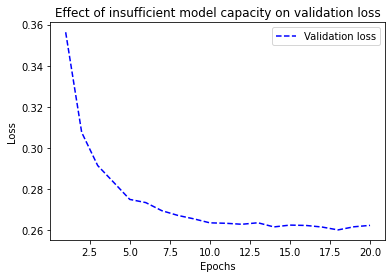

In [8]:
import matplotlib.pyplot as plt 

val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
        label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 과대적합할 수 없는 거서럼 보이다면 모델의 표현능력이 부족한 것,

In [10]:
# 96개의 유닛을 가진 2개의 중간층으로 구성되어 용량이 더 큰 모델을 훈련해 보죠.
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=['accuracy'])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20, batch_size=128,
    validation_split=0.2
)

Epoch 1/20
375/375 [==============================] - 2s 5ms/step - loss: 0.3579 - accuracy: 0.8985 - val_loss: 0.1992 - val_accuracy: 0.9409
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1619 - accuracy: 0.9521 - val_loss: 0.1388 - val_accuracy: 0.9583
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1132 - accuracy: 0.9659 - val_loss: 0.1277 - val_accuracy: 0.9590
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0870 - accuracy: 0.9735 - val_loss: 0.1024 - val_accuracy: 0.9679
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0705 - accuracy: 0.9783 - val_loss: 0.0948 - val_accuracy: 0.9709
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0568 - accuracy: 0.9828 - val_loss: 0.0934 - val_accuracy: 0.9728
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0472 - accuracy: 0.9856 - val_loss: 0.0958 - val_accuracy: 0.9723
Epoch 

## 5.4 일반화 성능 향상하기
모델이 어느정도 일반화 성능을 갖고 과대적합할 수 있다면 이제 일반화를 극대화하는데 초점 <br>


### 5.4.1 데이터셋 큐레이션
- 데이터가 충분한지 확인 <br>
- 레이블 할당 에러를 최소화한다 <br>
- 데이터르 정제하고 누락된 값을 처리한다 <br>
- 많은 특성중에서 어떤 것이 유용한지 확실하지 않다면 특성 서택을 할수 있ㄷ. <br>

### 5.4.2 특성 공학(feature engineering)
- 데이터와 머신 러닝 알고리즘에 관한 지식을 사용하는 단계 <br>
- 딥러닝 이전에는 특성 공학이 머신 러닝 workflow에서 가장 중요한 부분, 전통적인 얕은 학습 방법의 알고리즘들은 스스로 유용한 특성을 학습할 만큼 충분히 넓은 가서 공간을 가지고 있지 않음, 따라서 알고리즘에 데이터를 표현하는 방식에 성공 여부가 달려 있음. <br>
- 다행히 최신 딥러닝은 대부분 특성 공학이 필요하지 않다, 신경망이 자동으로 원본 데이터에서 유용한 특성을 추출할 수 있기 때문, 그렇다면 심층 신경망을 사용할떄는 특성 공학에 대해 신경쓰지 않아도 될까? No, Here's two reashons why. <br>
    1. 좋은 특성은 적은 자원을 사용하여 문제를 더 멋지게 풀어낼 수 있다, 예를 들어 시계 바늘을 읽는 문제에 합성곱 신경망을 사용하는 것은 어울리지 않다. <br>
    2. 좋은 특성은 더 적은 데이터로 문제를 풀 수 있다. 딥러닝 모델이 스스로 특성을 학습하는 능력은 가용한 훈련 데이터가 많을 떄 발휘된다. 샘플 개수가 적다면 특성에 있는 정보가 매우 중요해진다. <br>


### 5.4.3 조기 종료 사용
EarlyStopping 콜백을 사용


### 5.4.4 모델 규제하기
- 규제(regularization)기법은 훈련 데이터에 완벽하게 맞추려는 모델의 능력을 적극적으로 방해하는 일련의 모범 사례, 모델의 검증 점수를 향상시키는 것이 목적 <br>
- 과대적합을 완화시키는 가장 간단한 방법은 모델크기(층의 수와 층에 있는 유닛개수로 결정되는 학습 가능한 파라미터 개수)를 줄이는 것, 너무 많은 용량과 충분하지 않은 용량 사이의 절충점을 찾아야함 <br>

#### 코드 5-10 원본 모델

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb

(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='softmax'),
])

model.compile(optimizer="rmsprop",
             loss="binary_crossentropy",
             metrics=["accuracy"])

history_original = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
29/30 [============================>.] - ETA: 0s - loss: 0.5445 - accuracy: 0.5022

In [ ]:
# 더 작은 모델로 바꿔보쟈
model = keras.Sequential([
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_smaller_model = model.fit(
    train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4
)

- 4번째 epoch가 아니라 6번쨰 epoch 작은 모델이 기본 모델보다 더 나중에 과대적합되기 시작 <br>
- 과대적합이 시작되었을 때 성능이 더 천천히 감소

#### 코드 5-12 큰 용량의 모델

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='softmax'),
])

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4
)

# 용량이 큰 모델은 첫번째 에포크 이후 거의 바로 과대적합이 시작되어 갈수록 더 심해진다, 검증 손실도 매우 불안정함, 

#### 가중치 규제 추가

'오캄의 면도날': 어떤 것에 대한 두가지의 설명이 있다면 더 적은 가정이 필요한 간단한 설명이 옳을 것이라는 이론 <br>

가중치 규제(weight regularization)이라고 하며, 모델의 손실 함수에 큰 가중치에 연관된 비용을 추가 <br>
- L1규제: 가중치의 절댓값에 비례하는 비용이 추가됨 (가중치의 L1노름(norm)) <br>
- L2규제: 가중치의 제곱에 비례하는 비용이 추가됨(가중치의 L2노름(norm), L2규제는 신경망에서 가중치 감쇠(weight decay)라고도 부름. 이름이 다르지만 혼동하지 마셈, 가중치 감쇠는 수학적으로 L2규제와 동일 <br>

#### 코드 5-13 모델에 L2 가중치 추가하기

In [ ]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(16, kernel_regularizer = regularizers.l2(0.02),
                activation='relu'),
    layers.Dense(16, kernel_regularizer = regularizers.l2(0.02),
                activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split =0.4
)

#### 코드 5-14 케라스에서 사용할 수 있는 가중치 규제

In [ ]:
from tensorflow.keras import regularizers

regularizers.l1(0.001)  # ㅣ1규제
regularizers.l1_l2(l1=0.001, l2 = 0.001)  # l1규제와 l2규제 병행

#### 드롭아웃 추가 

모델층에 드롭아웃을 적용하면 훈련하는 동안 무작위로 층의 출력 특성ㅇ르 일부 제외시킴(0으로 만듦)

In [ ]:
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)  # 훈련할 때 유닛의 출력 중 50%를 버림
layer_output *= 0.5  # 테스트 단계
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)  # 훈련 단계
layer_output .= 0.5  # 여기에서 스케일을 낮추는 대신 높임

- 핵심 아이디어는 층의 출력값에 노이즈를 추가하여 중요하지 않은 우연한 패턴(힌틴이 이야기한 부정한 협업)을 깨뜨리는 것임
- 노이즈가 없다면 모델이 이 패턴을 기억하기 시작할 것

#### 코드 5-15 IMDB 모델에 드롭아웃 추가하기

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsporp',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size = 512, validation_split = 0.4
)

신경망에서 일반화 성능을 극대화하고 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같다.

- 훈련 데이터를 더 모음, 또는 더 나은 데이터를 모음 <br>
- 더 나은 특성을 개발 <br>
- 네트워크의 용량을 감소 <br>
- (작은 모델을 만들기 위해) 가중치 규제를 추가 <br>
- 드롭아웃을 추가 <br>



## 5.5 요약
- 머신러닝 모델의 목적은 이전에 본 적 없는 입력에서 정확하게 동작하는 일반화 <br>
- 심층 신경망은 훈련 샘플 사이를 성공적으로 보간 할 수 있는 모수 모델(parametric model)을 훈련하여 일반화를 달성, '잠재 매니폴드'를 학습해다고 말할 수 있음 <br>
- 머신러닝의 근본적인 문제는 최적화와 일반화 사이의 줄다리기: 일반화를 달성하기 위해 먼저 훈련 데이터에 잘 맞추어야 하지만 훈련 데이터에 대한 성능 향상은 잠시 후 불가피하게 일반화를 저해함 <br>
- 딥러닝 모델의 일반화 능력은 데이터의 잠재 매니폴드를 근사하는 방법을 학습하고 보간을 통해 새로운 입력을 이해할 수 있다는 사실에서 비롯됨 <br>
- 모델을 개발하는 동안 모델의 일반화 능력을 정확하게 평가할 수 있어야 함. <br>
- 모델을 구축하기 시작할 때 먼저 약간의 일반화 능력을 가지고 과대적합할 수 있느 모델을 만드는 것이 목표 <br>
- 모델이 과대적합되기 시작할 떄 규제를 통해 일반화 성능을 향상시키도록 목표가 바뀜 <br>